<a href="https://colab.research.google.com/github/mshreeharsha/HuBMAP---Hacking-the-Human-Vasculature-FA-Major-Project/blob/main/efficientNet/HuBMAP_Hacking_the_Human_Vasculature_FA_Major_Project_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
#Paths to files
basePath = "/content/drive/MyDrive/HuBMAP_Hacking_the_Human_Vasculature"
imagesFolder = basePath + "/train/"
labelsPath = basePath + "/polygons.jsonl"

In [55]:
import torch
from torch.utils.data import Dataset
import json
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [56]:
class LabelDataset(Dataset):
    def __init__(self, labelsPath, imagePath):
        self.labelsDataset = self.getLabelDataset(labelsPath)
        self.labelsPath = labelsPath
        self.imagePath = imagePath

    def getLabelDataset(self, labelsPath):
        with open(labelsPath) as jsonFile:
            jsonList = list(jsonFile)

        labelsDataset = []
        for jsonStr in jsonList:
            result = json.loads(jsonStr)
            # result -> {id:"", annotations:[]}
            annotations = result['annotations']

            for ann in annotations:
                if ann["type"] != "blood_vessel":
                    continue
                row = {
                    "id": result["id"],
                    "coordinates": ann["coordinates"],
                }
                labelsDataset.append(row)

        return pd.DataFrame(labelsDataset, columns=["id", "coordinates"])

    def generateMask(self, imageID):
        mask = np.zeros((512, 512, 1), dtype=np.uint8)
        annotations = self.labelsDataset[self.labelsDataset['id'] == imageID]
        for _, row in annotations.iterrows():
            coordinates = np.array(row["coordinates"])
            mask = cv2.fillPoly(mask, [coordinates], 1)
        return mask

    def __len__(self):
        return len(self.labelsDataset['id'].unique())

    def __getitem__(self, index):
        uniqueIDs = self.labelsDataset['id'].unique()
        imgID = uniqueIDs[index]
        imagePath = f"{self.imagePath}/{imgID}.tif"
        image = cv2.imread(imagePath, cv2.COLOR_BGR2RGB)
        mask = self.generateMask(imageID=imgID)

        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)

        #Numpy array to tensors
        # mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        image = np.array(image) / 255.0
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        return image,mask,imgID


In [57]:
labels = LabelDataset(labelsPath,imagesFolder)
print(f"Number of ID-s removed, where 'blood_vessel' were missing: {1633-len(labels)}")

Number of ID-s removed, where 'blood_vessel' were missing: 11


In [58]:
testLen = int(0.2*len(labels))
lengths = [len(labels)-testLen, testLen]
trainSet, testSet = torch.utils.data.random_split(labels, lengths)

# reducedTrainLen = int(0.5 * len(trainSet))
# trainSet, _ = torch.utils.data.random_split(trainSet, [reducedTrainLen, len(trainSet) - reducedTrainLen])
print(f"train set: {len(trainSet)}, test set: {len(testSet)}")

train set: 1298, test set: 324


In [59]:
valLen = int(0.2*len(trainSet))
lengths = [len(trainSet)-valLen, valLen]
trainSet, valSet = torch.utils.data.random_split(trainSet, lengths)
print(f"train set: {len(trainSet)}, validation set: {len(valSet)}")


train set: 1039, validation set: 259


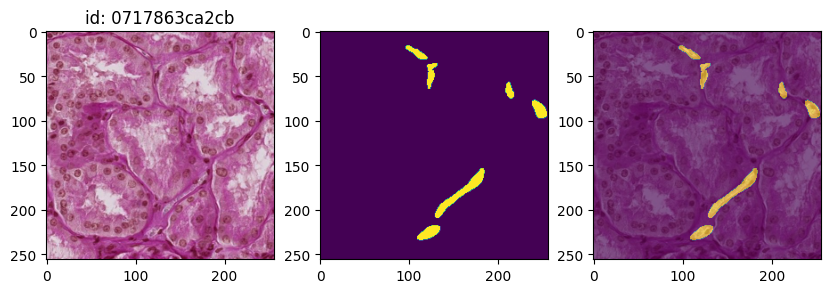

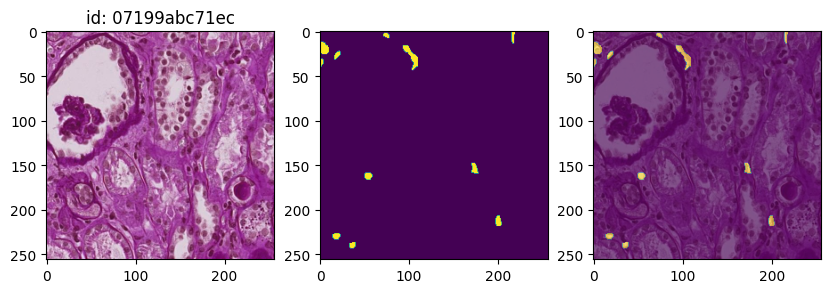

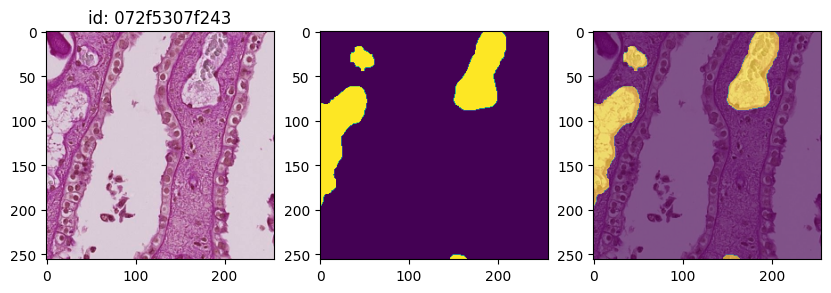

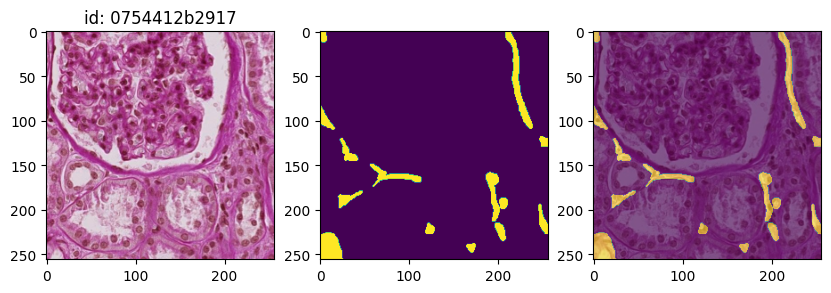

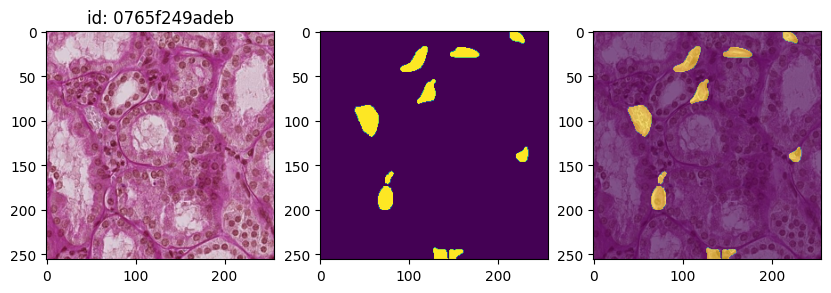

In [ ]:
samples = [labels[i] for i in range(40,45)]

for sample in samples:
    masks = sample[1].squeeze(0)
    image = sample[0].permute(1,2,0).numpy()

    fig, axs = plt.subplots(1,3,figsize=(10,8))
    axs[0].imshow(image)
    axs[0].set_title(f"id: {sample[2]}")
    axs[1].imshow(masks)
    axs[2].imshow(image)
    axs[2].imshow(masks, alpha=0.6)
    plt.show()

In [8]:
pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=6408bfb66fa57d5c59bd949b2ca95705eb5ad9a9080562401a694990453bb500
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=c9c64e43eceea6616fc4a61fb6ddbc9ca2ff95c93b2f9436d799cdc02274148d
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [9]:
pip install torchinfo

In [60]:
import segmentation_models_pytorch as smp
from torchinfo import summary
import torch.nn as nn
import torch.nn.functional as F
import keras
import keras.backend as K
from torch.utils.data import DataLoader
from datetime import datetime
import gc

In [61]:
import ssl
import requests

# Disable SSL verification
ssl._create_default_https_context = ssl._create_unverified_context

models =[]
models.append(smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
))
models.append(smp.Unet(
    encoder_name="efficientnet-b2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
))
models.append(smp.Unet(
    encoder_name="densenet169",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
))


In [62]:
summary(models[1], input_size=(1,3,256,256), col_names=['input_size','output_size','num_params','trainable'])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
Unet                                                    [1, 3, 256, 256]          [1, 1, 256, 256]          --                        True
├─EfficientNetEncoder: 1-1                              [1, 3, 256, 256]          [1, 3, 256, 256]          498,432                   True
│    └─Conv2dStaticSamePadding: 2-1                     [1, 3, 256, 256]          [1, 32, 128, 128]         864                       True
│    │    └─ZeroPad2d: 3-1                              [1, 3, 256, 256]          [1, 3, 257, 257]          --                        --
│    └─BatchNorm2d: 2-2                                 [1, 32, 128, 128]         [1, 32, 128, 128]         64                        True
│    └─MemoryEfficientSwish: 2-3                        [1, 32, 128, 128]         [1, 32, 128, 128]         --                        --
│    └─ModuleList: 2-4    

In [63]:
class config:
    imgSize = 256
    inChannel = 3
    numClasses = 1
    batchSize = 16
    initLR = 1e-3
    weightDecay = 1e-4
    epochs = 40

In [64]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [65]:
#Train Loader
trainLoader = DataLoader(trainSet, batch_size=config.batchSize, shuffle=True)

In [66]:
#Validation Loader
valLoader = DataLoader(valSet, batch_size=config.batchSize, shuffle=True)

In [67]:
#Statistics
def calculateStatistics(labels, preds):
    predClass = torch.sigmoid(preds).round()
    numOfCorrect = (predClass == labels).sum().item()
    numOfPixels = labels.numel()

    intersection = (predClass * labels).sum().item()
    union = (predClass + labels).sum().item() - intersection

    if union > 0:
        pixel_acc = numOfCorrect / numOfPixels * 100
        iou = intersection / union * 100
        dice_score = (2 * intersection) / ((predClass + labels).sum().item() + 1e-8)
    else:
        pixel_acc = 0
        iou = 0
        dice_score = 0

    return dice_score, iou, pixel_acc

In [68]:
def saveCheckpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Checkpoint saved at epoch {epoch}, loss: {loss:.4f}, path: {path}")


In [69]:
modelSavePath = "/content/drive/MyDrive/HuBMAP_Hacking_the_Human_Vasculature/training/efficientNETb2_AllImages_withVal.pt"

In [ ]:
#Training Loop Func
def training(trainLoader, model, lossFunc, optimizer, totalEpochs, startEpoch, device="cuda"):
    history = {
        "epoch": [],
        "train_loss": [],
        "diceScore": [],
        "iou": [],
        "pixelAcc": [],
    }

    for e in range(startEpoch,totalEpochs):
        model.train()
        print("-" * 40)
        print(f"EPOCH {e + 1}/{totalEpochs}. training step...")

        trainTimeStart = datetime.now()
        lossList = []
        totalDiceScores = 0
        totalIOU = 0
        totalPixelAcc = 0

        for i, data in enumerate(trainLoader):
            print("Batch No : ",i)
            image = data[0].to(device)
            segGroundTruth = data[1].to(device)

            # Forward pass
            segPred = model(image)

            loss = lossFunc(segPred, segGroundTruth)

            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            lossList.append(loss.item())

            diceScore, iou, pixelAcc = calculateStatistics(labels=segGroundTruth, preds=segPred)
            totalDiceScores += diceScore
            totalIOU += iou
            totalPixelAcc += pixelAcc

        avgTrainLoss = np.mean(lossList)
        avgDiceScores = totalDiceScores / len(trainLoader)
        avgIOU = totalIOU / len(trainLoader)
        avgPixelAcc = totalPixelAcc / len(trainLoader)

        train_time_end = datetime.now() - trainTimeStart
        print(f" - Train epoch mean loss: {avgTrainLoss:.4f}")
        print(f" - Dice score: {avgDiceScores:.4f}")
        print(f" - IoU: {avgIOU:.2f}%")
        print(f" - Pixel accuracy: {avgPixelAcc:.2f}%")
        print(f" - Epoch training time: {train_time_end}\n")

        history["epoch"].append(e + 1)
        history["train_loss"].append(avgTrainLoss)
        history["diceScore"].append(avgDiceScores)
        history["iou"].append(avgIOU)
        history["pixelAcc"].append(avgPixelAcc)

        saveCheckpoint(model, optimizer, e, avgTrainLoss, modelSavePath)

    return history

In [70]:
def training(trainLoader, validLoader, model, lossFunc, optimizer, totalEpochs, startEpoch, device="cuda"):
    history = {
        "epoch": [],
        "train_loss": [],
        "valid_loss": [],
        "diceScore": [],
        "iou": [],
        "pixelAcc": [],
    }

    prevValLoss = np.Inf
    earlyStoppingCounter = 0
    earlyStoppingLimit = 5

    for e in range(startEpoch, totalEpochs):
        model.train()
        print("-" * 40)
        print(f"EPOCH {e + 1}/{totalEpochs}. training step...")

        trainTimeStart = datetime.now()
        lossList = []
        totalDiceScores = 0
        totalIOU = 0
        totalPixelAcc = 0

        # Training Loop
        for i, data in enumerate(trainLoader):
            print("Batch No : ", i)
            image = data[0].to(device)
            segGroundTruth = data[1].to(device)

            # Forward pass
            segPred = model(image)
            loss = lossFunc(segPred, segGroundTruth)

            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            lossList.append(loss.item())

            diceScore, iou, pixelAcc = calculateStatistics(labels=segGroundTruth, preds=segPred)
            totalDiceScores += diceScore
            totalIOU += iou
            totalPixelAcc += pixelAcc

        avgTrainLoss = np.mean(lossList)
        avgDiceScores = totalDiceScores / len(trainLoader)
        avgIOU = totalIOU / len(trainLoader)
        avgPixelAcc = totalPixelAcc / len(trainLoader)

        train_time_end = datetime.now() - trainTimeStart
        print(f" - Train epoch mean loss: {avgTrainLoss:.4f}")
        print(f" - Dice score: {avgDiceScores:.4f}")
        print(f" - IoU: {avgIOU:.2f}%")
        print(f" - Pixel accuracy: {avgPixelAcc:.2f}%")
        print(f" - Epoch training time: {train_time_end}\n")

        # Validation Loop
        model.eval()
        print(f"EPOCH {e + 1}/{totalEpochs}. validation step...")
        valLossList = []
        totalValDiceScores = 0
        totalValIoU = 0
        totalValPixelAcc = 0

        with torch.no_grad():
            for i, data in enumerate(validLoader):
                image = data[0].to(device)
                segGroundTruth = data[1].to(device)

                segPred = model(image)
                val_loss = lossFunc(segPred, segGroundTruth)
                valLossList.append(val_loss.item())

                diceScore, iou, pixelAcc = calculateStatistics(labels=segGroundTruth, preds=segPred)
                totalValDiceScores += diceScore
                totalValIoU += iou
                totalValPixelAcc += pixelAcc

        avgValidLoss = np.mean(valLossList)
        avgValDiceScores = totalValDiceScores / len(validLoader)
        avgValIOU = totalValIoU / len(validLoader)
        avgValPixelAcc = totalValPixelAcc / len(validLoader)

        print(f"Validation Results:")
        print(f" - Valid epoch mean loss: {avgValidLoss:.4f}")
        print(f" - Dice score: {avgValDiceScores:.4f}")
        print(f" - IoU: {avgValIOU:.2f}%")
        print(f" - Pixel accuracy: {avgValPixelAcc:.2f}%\n")

        history["epoch"].append(e + 1)
        history["train_loss"].append(avgTrainLoss)
        history["valid_loss"].append(avgValidLoss)
        history["diceScore"].append(avgValDiceScores)
        history["iou"].append(avgValIOU)
        history["pixelAcc"].append(avgValPixelAcc)

        # Save model if validation loss improves
        if avgValidLoss < prevValLoss:
            print(f" - Lower validation loss achieved ({prevValLoss:.4f} --> {avgValidLoss:.4f}). Saving model...")
            saveCheckpoint(model, optimizer, e, avgTrainLoss, modelSavePath)
            prevValLoss = avgValidLoss
            earlyStoppingCounter = 0
        else:
            earlyStoppingCounter += 1
            print(f" - Validation loss did not improve. Early stopping counter {earlyStoppingCounter}/{earlyStoppingLimit}")

        # Early stopping
        # if earlyStoppingCounter >= earlyStoppingLimit:
        #     print("Early stopping triggered.")
        #     break

        # Clear cache after epoch
        torch.cuda.empty_cache()
        gc.collect()

    return history


In [71]:
lossFunc = DiceBCELoss()
optimizer = torch.optim.AdamW(models[1].parameters(), lr=config.initLR, weight_decay=config.weightDecay)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
def loadCheckpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    print(f"Checkpoint loaded from epoch {epoch}, loss: {loss:.4f}")

    return model, optimizer, epoch, loss


In [73]:
history = training(trainLoader, valLoader, models[1], lossFunc, optimizer, config.epochs,0,device)

----------------------------------------
EPOCH 1/40. training step...
Batch No :  0
Batch No :  1
Batch No :  2
Batch No :  3
Batch No :  4
Batch No :  5
Batch No :  6
Batch No :  7
Batch No :  8
Batch No :  9
Batch No :  10
Batch No :  11
Batch No :  12
Batch No :  13
Batch No :  14
Batch No :  15
Batch No :  16
Batch No :  17
Batch No :  18
Batch No :  19
Batch No :  20
Batch No :  21
Batch No :  22
Batch No :  23
Batch No :  24
Batch No :  25
Batch No :  26
Batch No :  27
Batch No :  28
Batch No :  29
Batch No :  30
Batch No :  31
Batch No :  32
Batch No :  33
Batch No :  34
Batch No :  35
Batch No :  36
Batch No :  37
Batch No :  38
Batch No :  39
Batch No :  40
Batch No :  41
Batch No :  42
Batch No :  43
Batch No :  44
Batch No :  45
Batch No :  46
Batch No :  47
Batch No :  48
Batch No :  49
Batch No :  50
Batch No :  51
Batch No :  52
Batch No :  53
Batch No :  54
Batch No :  55
Batch No :  56
Batch No :  57
Batch No :  58
Batch No :  59
Batch No :  60
Batch No :  61
Batch No :

In [ ]:
def loadCheckpoint2(model, optimizer, path, device="cuda"):
    # Load the checkpoint, mapping to CPU if GPU is not available
    checkpoint = torch.load(path, map_location=torch.device(device))

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    print(f"Checkpoint loaded from epoch {epoch}, loss: {loss:.4f}")

    return model, optimizer, epoch, loss


In [74]:
model = models[1]
lossFunc = DiceBCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.initLR, weight_decay=config.weightDecay)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the checkpoint
# model, optimizer, startEpoch, lastLoss = loadCheckpoint2(model, optimizer, modelSavePath,"cpu")
model, optimizer, startEpoch, lastLoss = loadCheckpoint(model, optimizer, modelSavePath) #For GPU
model= model.to(device)


<ipython-input-72-22b8044dea25>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Checkpoint loaded from epoch 23, loss: 0.2024


In [ ]:
history = training(trainLoader, model, lossFunc, optimizer, config.epochs,startEpoch+1,device)

In [75]:
#test Loader
testLoader = DataLoader(testSet, batch_size=config.batchSize, shuffle=True)

In [76]:
def displayPrediction(image,trueMask,predictedMask):
    image = image.detach().cpu()
    trueMask = trueMask.detach().cpu()
    predictedMask = predictedMask.detach().cpu()
    predictedMask = torch.sigmoid(predictedMask)
    predictedMask = (predictedMask > 0.5).float()
    image = image.permute(1, 2, 0).numpy()
    fig, axs = plt.subplots(1,3,figsize=(10,8))
    axs[0].imshow(image)
    axs[0].set_title("Test Image")
    axs[1].imshow(trueMask.permute(1, 2, 0).squeeze().numpy(), cmap="gray")
    axs[1].set_title("Original Mask")
    axs[2].imshow(predictedMask.squeeze().numpy(), cmap="gray")
    axs[2].set_title("Predicted Mask")
    plt.show()

In [77]:
def testModel(testLoader, model, device):
    model.eval()
    totalDiceScore = 0
    totalIOU = 0
    totalPixelAcc = 0
    testLoss = 0
    numBatches = len(testLoader)

    with torch.no_grad():
        for batchNo, data in enumerate(testLoader):
            image = data[0].to(device)
            mask = data[1].to(device)

            outputs = model(image)

            outputs = torch.sigmoid(outputs)
            outputs = (outputs > 0.5).float()

            loss = lossFunc(outputs, mask)
            testLoss += loss.item()

            # Calculate metrics (Dice, IoU, Pixel Accuracy)
            diceScore, iou, pixelAcc = calculateStatistics(labels=mask, preds=outputs)
            totalDiceScore += diceScore
            totalIOU += iou
            totalPixelAcc += pixelAcc

            print(f"Batch {batchNo + 1}/{numBatches} - Loss: {loss.item():.4f} - Dice: {diceScore:.4f} - IoU: {iou:.2f}% - Pixel Acc: {pixelAcc:.2f}%")
            displayPrediction(image[0],mask[0],outputs[0])

    avgDiceScore = totalDiceScore / numBatches
    avgIOU = totalIOU / numBatches
    avgPixelAcc = totalPixelAcc / numBatches
    avgTestLoss = testLoss / numBatches

    return avgDiceScore, avgIOU, avgPixelAcc, avgTestLoss


Batch 1/21 - Loss: 1.5703 - Dice: 0.6488 - IoU: 48.01% - Pixel Acc: 96.27%


Batch 2/21 - Loss: 1.6103 - Dice: 0.6087 - IoU: 43.75% - Pixel Acc: 97.51%


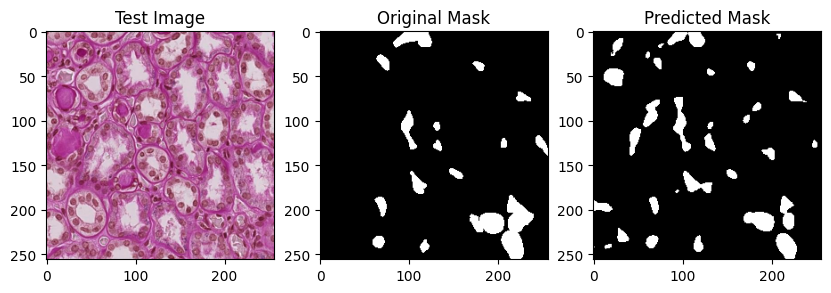

Batch 3/21 - Loss: 1.5925 - Dice: 0.5590 - IoU: 38.80% - Pixel Acc: 96.54%


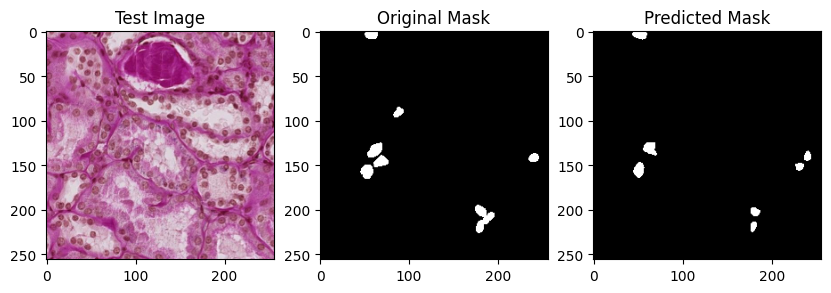

Batch 4/21 - Loss: 1.5743 - Dice: 0.7368 - IoU: 58.33% - Pixel Acc: 97.68%


Batch 5/21 - Loss: 1.5993 - Dice: 0.7152 - IoU: 55.67% - Pixel Acc: 97.87%


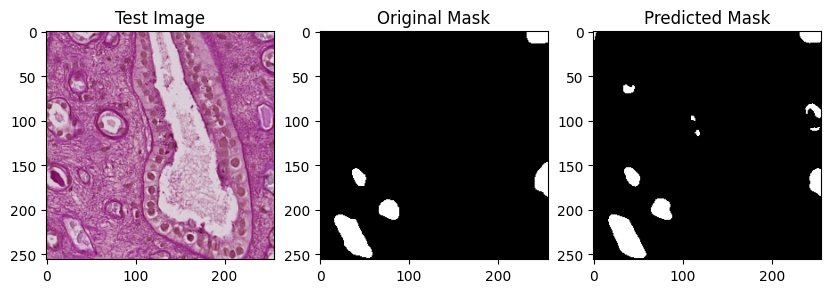

Batch 6/21 - Loss: 1.6218 - Dice: 0.5295 - IoU: 36.01% - Pixel Acc: 97.57%


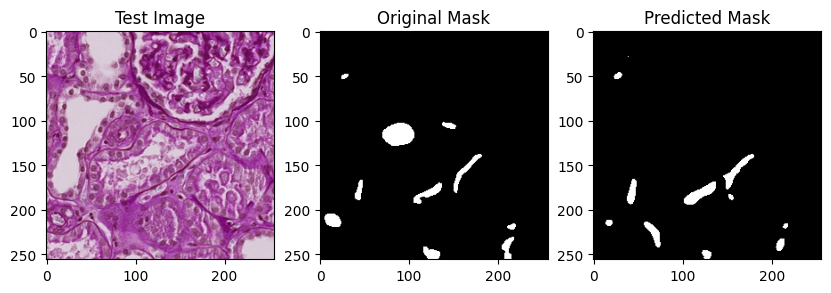

Batch 7/21 - Loss: 1.5918 - Dice: 0.7125 - IoU: 55.34% - Pixel Acc: 97.60%


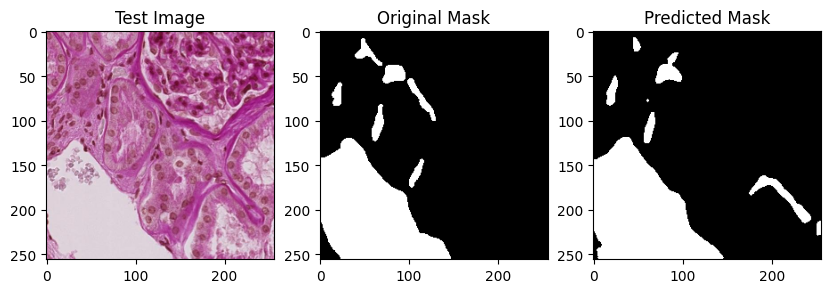

Batch 8/21 - Loss: 1.6396 - Dice: 0.5569 - IoU: 38.59% - Pixel Acc: 97.66%


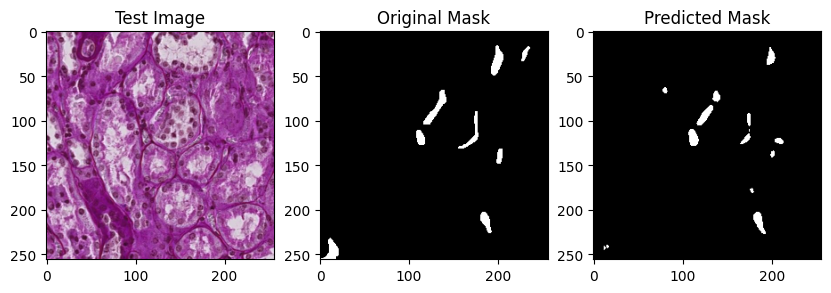

Batch 9/21 - Loss: 1.5612 - Dice: 0.7446 - IoU: 59.31% - Pixel Acc: 97.46%


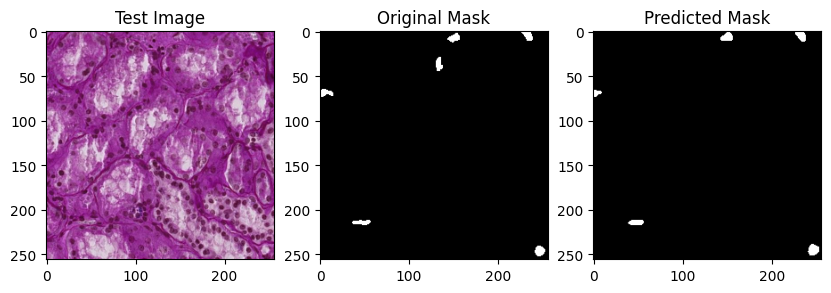

Batch 10/21 - Loss: 1.5974 - Dice: 0.5923 - IoU: 42.08% - Pixel Acc: 97.11%


Batch 11/21 - Loss: 1.5892 - Dice: 0.5910 - IoU: 41.94% - Pixel Acc: 96.89%


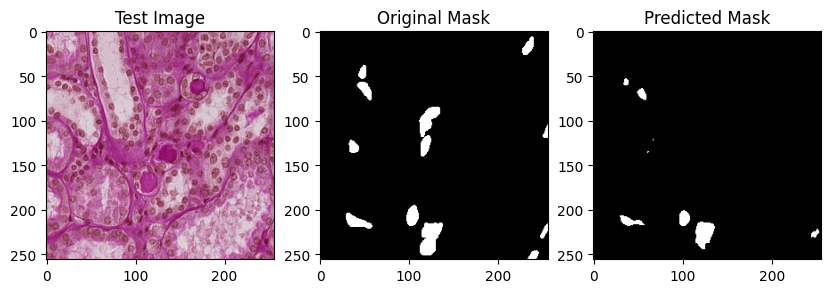

Batch 12/21 - Loss: 1.6105 - Dice: 0.6419 - IoU: 47.27% - Pixel Acc: 97.67%


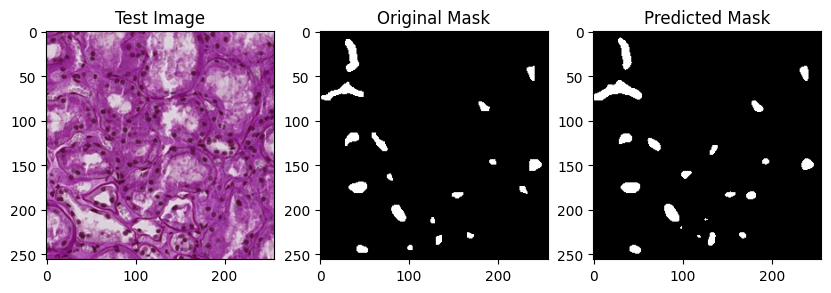

Batch 13/21 - Loss: 1.6218 - Dice: 0.6272 - IoU: 45.69% - Pixel Acc: 97.81%


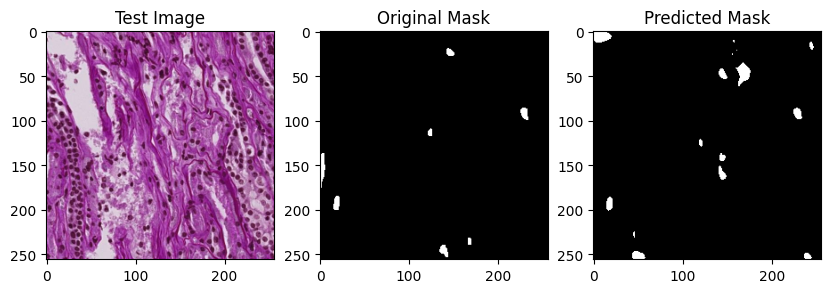

Batch 14/21 - Loss: 1.5709 - Dice: 0.6285 - IoU: 45.82% - Pixel Acc: 96.49%


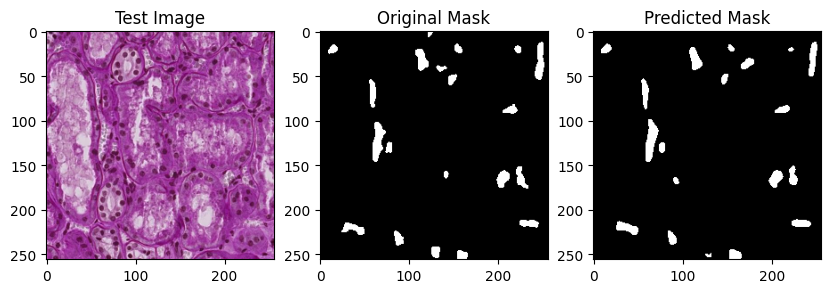

Batch 15/21 - Loss: 1.5858 - Dice: 0.6330 - IoU: 46.31% - Pixel Acc: 97.03%


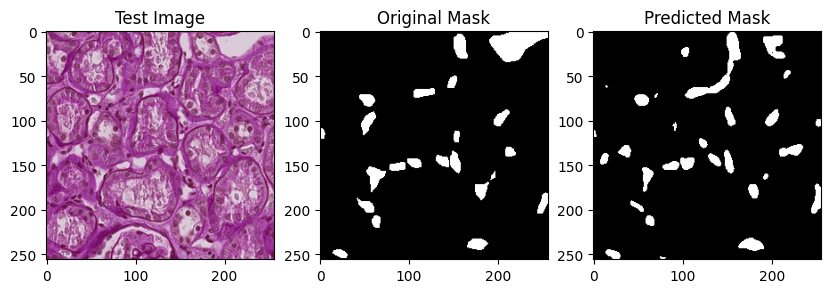

Batch 16/21 - Loss: 1.5899 - Dice: 0.5446 - IoU: 37.42% - Pixel Acc: 96.48%


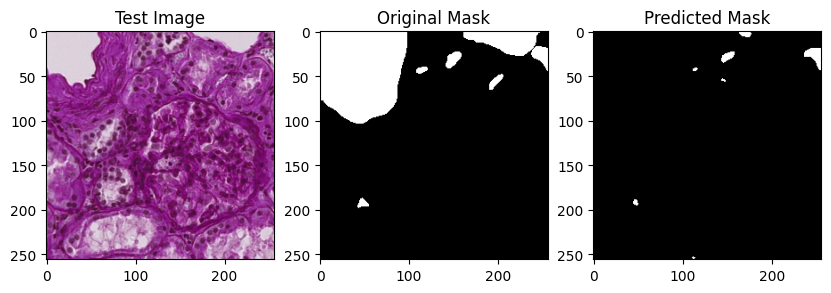

Batch 17/21 - Loss: 1.5978 - Dice: 0.6947 - IoU: 53.23% - Pixel Acc: 97.73%


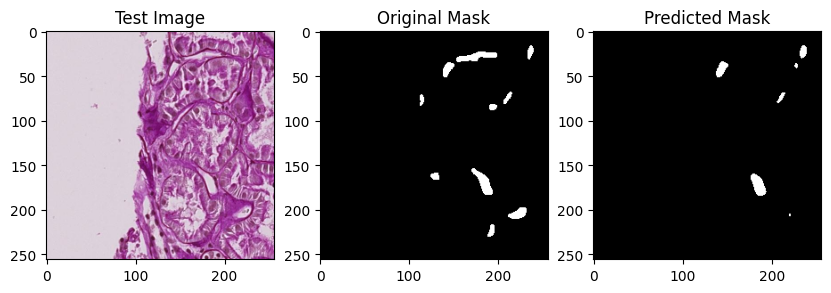

Batch 18/21 - Loss: 1.5685 - Dice: 0.5300 - IoU: 36.06% - Pixel Acc: 95.70%


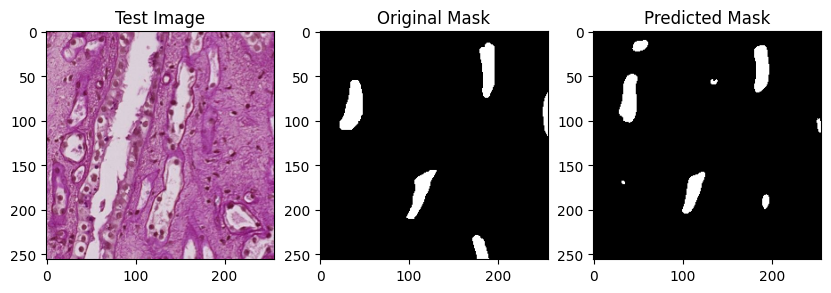

Batch 19/21 - Loss: 1.5961 - Dice: 0.6398 - IoU: 47.04% - Pixel Acc: 97.27%


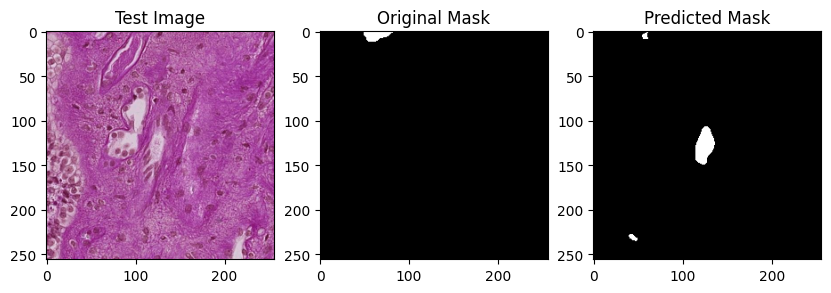

Batch 20/21 - Loss: 1.5392 - Dice: 0.6944 - IoU: 53.19% - Pixel Acc: 96.22%


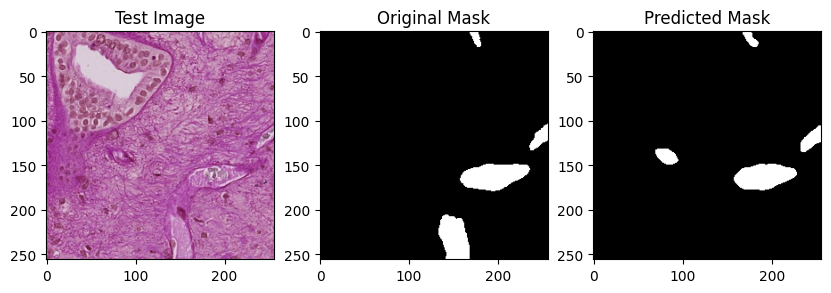

Batch 21/21 - Loss: 1.6432 - Dice: 0.7148 - IoU: 55.61% - Pixel Acc: 99.02%


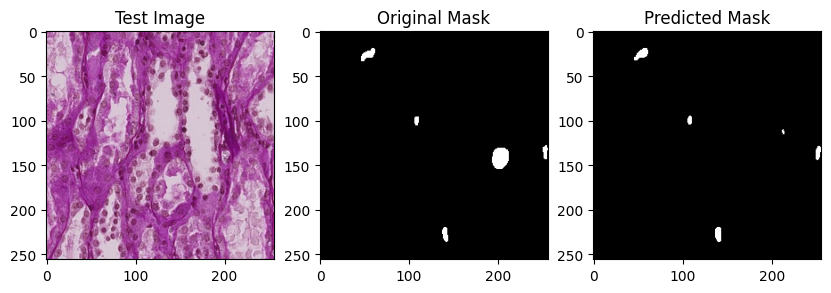

Test Dice :  0.6354402830650837
Test IoU :  46.92615989266377
Test Pixel Accuarcy :  97.21836362566266
Test Loss :  1.5938746702103388


In [80]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
testDice, testIOU, testPixelAcc, testLoss = testModel(testLoader, model, device)
print("Test Dice : ",testDice)
print("Test IoU : ",testIOU)
print("Test Pixel Accuarcy : ",testPixelAcc)
print("Test Loss : ",testLoss)